In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Functions to read + generate/scale pandas dataframe from npz files

In [2]:
def read_mf_norm(fname='mfields.npz'):
    # Normalize everything by urms = B_eq
    mf = np.load(fname)
    bxm = mf['bxm']/mf['uave']
    bym = mf['bym']/mf['uave']
    jxm = mf['jxm']/mf['uave']
    jym = mf['jym']/mf['uave']
    Exm = mf['emfx']/mf['uave']
    Eym = mf['emfy']/mf['uave']
    return bxm, bym, jxm, jym, Exm, Eym

def ave_t(arr,tone=1000,ttwo=2000,verbose=None):
    if verbose:
        print(f't1: {tone}, t2: {ttwo}')
    return np.mean(arr[tone:ttwo,:],axis=0)

def gen_df_tave(fname='mfields.npz',t1=1000,t2=2000,verbose=None):
    '''
    Generate a dataframe by averaging squared fields over t from t1 to t2
    '''

    if verbose:
        print(f"Generating time averaged dataframe with t1: {t1} and t2: {t2}")
  
    bxm,bym,jxm,jym,Exm,Eym = read_mf_norm(fname=fname)
    
    return pd.DataFrame.from_dict({
        'Bx': ave_t(bxm,tone=t1,ttwo=t2),
        'By': ave_t(bym,tone=t1,ttwo=t2),
        'Jx': ave_t(jxm,tone=t1,ttwo=t2),
        'Jy': ave_t(jym,tone=t1,ttwo=t2),
        'Ex': -1. * ave_t(Exm,tone=t1,ttwo=t2), # changed signs
        'Ey': -1. * ave_t(Eym,tone=t1,ttwo=t2)  # Since PENCIL computes -VxB
        })

def scale_df(df):
    '''
    Call:   df_ss, scl = scale_df(df)
    Inv. Transform: dfn = scl.inverse_transform(df_ss)
    Check equality: np.allclose(df.to_numpy(),dfn.to_numpy())
    '''

    from sklearn.preprocessing import StandardScaler
    df_ss = df.copy()
    scl   = StandardScaler()
    df_ss = scl.fit_transform(df_ss)
    return pd.DataFrame(df_ss,columns=df.columns),scl

## Download data for 4 different runs

In [3]:
files_dict = {
    'mfields_R5e2.npz':  "https://sid.erda.dk/public/archives/0cf0c2b6d34e20da8971304b06d8f913/pencil/alpha2/k10_R500_256_test_xyaver_alpha_eta/mfields.npz",
    'mfields_R1e3.npz':  "https://sid.erda.dk/public/archives/0cf0c2b6d34e20da8971304b06d8f913/pencil/alpha2/k10_R1000_256_test_xyaver_alpha_eta/mfields.npz",
    'mfields_R5e3.npz':  "https://sid.erda.dk/public/archives/0cf0c2b6d34e20da8971304b06d8f913/pencil/alpha2/k10_R5000_256_test_xyaver_alpha_eta/mfields.npz",
    'mfields_R15e3.npz': "https://sid.erda.dk/public/archives/0cf0c2b6d34e20da8971304b06d8f913/pencil/alpha2/shock_k10_R15000_256_xyaver_alpha_eta/mfields.npz"
}

In [9]:
# Step 1: Create alpha2 folder if it does not exist
try:
    os.makedirs("alpha2")
except FileExistsError:
    pass

# Step 2: Download the files if they do not exist
for key, value in files_dict.items():
    exists = os.path.isfile(f"alpha2/{key}")
    if exists:
        print("File " + f"{key}" + " already exists")
        pass
    else:
        print(f"Downloading file: {key}")
        !wget -O alpha2/{key} {value}

File mfields_R5e2.npz already exists
File mfields_R1e3.npz already exists
File mfields_R5e3.npz already exists
File mfields_R15e3.npz already exists


In [6]:
# LOAD data into dataframes
pth = 'alpha2/'

df15 = gen_df_tave(fname=pth + 'mfields_R15e3.npz',t1=1500,t2=-1)
df5  = gen_df_tave(fname=pth + 'mfields_R5e3.npz',t1=1000,t2=-1)
df1  = gen_df_tave(fname=pth + 'mfields_R1e3.npz',t1=1250,t2=2000)
df05 = gen_df_tave(fname=pth + 'mfields_R5e2.npz',t1=4000,t2=5000)

In [32]:
# SCALING useful for correlations/plots
data_ss, _ = scale_df(df15)

# repace the above with scale_df(df05) to plot Rm=500 for example

Text(0.5, 0, 'z')

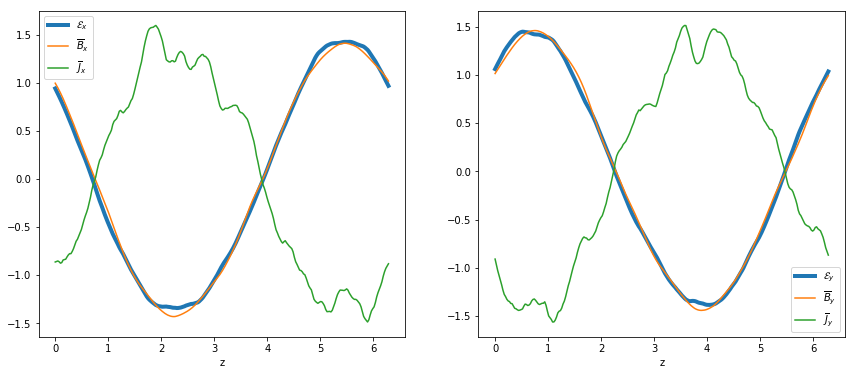

In [13]:
z_ax = np.linspace(0,2*np.pi,256)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
plt.subplots_adjust(left=0.2, hspace=0.25)

ax1.plot(z_ax,data_ss['Ex'],lw=4,label=r'$\mathcal{E}_x$')
ax1.plot(z_ax,data_ss['Bx'],label=r'$\overline{B}_x$')
ax1.plot(z_ax,data_ss['Jx'],label=r'$\overline{J}_x$')
ax1.legend()
ax1.set_xlabel('z', fontsize=12)

ax2.plot(z_ax,data_ss['Ey'],lw=4,label=r'$\mathcal{E}_y$')
ax2.plot(z_ax,data_ss['By'],label=r'$\overline{B}_y$')
ax2.plot(z_ax,data_ss['Jy'],label=r'$\overline{J}_y$')
ax2.legend()
ax2.set_xlabel('z', fontsize=12)

## Figure 1 in the paper is a 3D phase space plot - an alternative view in 2D phase space

Projected onto 2D phase space, it is clearer that both EMFs and B fields have a simple sinusoidal structure

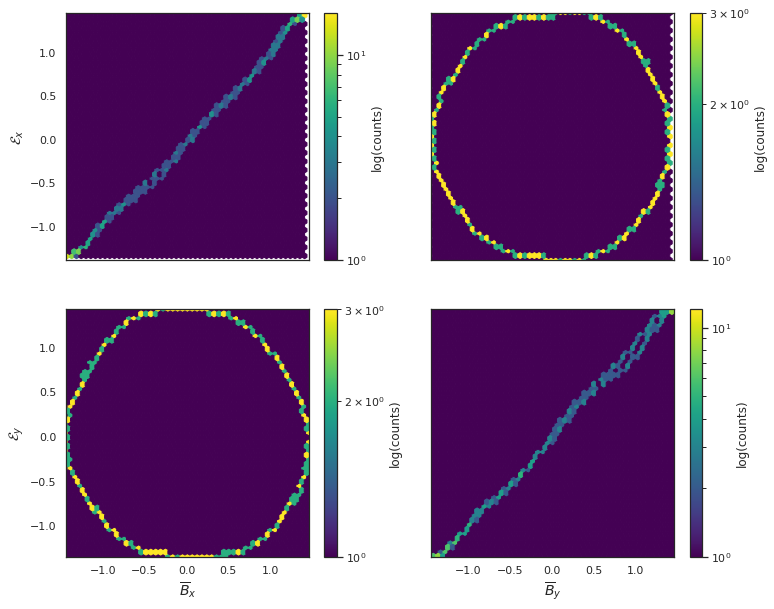

In [31]:
#bxm, bym, jxm, jym, Exm, Eym = read_mf_norm(fname=pth + 'mfields_R15e3.npz')
mf_ss = data_ss.to_numpy()

x1, x2, y1, y2 = mf_ss[:,0], mf_ss[:,1], mf_ss[:,4], mf_ss[:,5] 
#x1, x2, y1, y2 = mf_ss[:,0], mf_ss[:,1], mf_ss[:,2], mf_ss[:,3] -- use this for B vs J hexbin

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,10), sharex='col', sharey='row')

hb1 = ax1.hexbin(x1, y1, gridsize=50, bins='log', cmap='viridis')
ax1.axis([x1.min(),x1.max(),y1.min(),y1.max()])
ax1.set_ylabel(r'$\mathcal{E}_x$',fontsize=14)
cb = fig.colorbar(hb1, ax=ax1)
cb.set_label('log(counts)')

hb2 = ax2.hexbin(x1, y2, gridsize=50, bins='log', cmap='viridis')
ax2.axis([x1.min(),x1.max(),y2.min(),y2.max()])
cb = fig.colorbar(hb2, ax=ax2)
cb.set_label('log(counts)')

hb3 = ax3.hexbin(x2, y1, gridsize=50, bins='log', cmap='viridis')
ax3.axis([x2.min(),x2.max(),y1.min(),y1.max()])
ax3.set_xlabel(r'$\overline{B}_x$',fontsize=14)
ax3.set_ylabel(r'$\mathcal{E}_y$',fontsize=14)
cb = fig.colorbar(hb3, ax=ax3)
cb.set_label('log(counts)')

hb4 = ax4.hexbin(x2, y2, gridsize=50, bins='log', cmap='viridis')
ax4.axis([x2.min(),x2.max(),y1.min(),y1.max()])
ax4.set_xlabel(r'$\overline{B}_y$',fontsize=14)
cb = fig.colorbar(hb4, ax=ax4)
cb.set_label('log(counts)')

#fig.savefig('hexbin_allin1.pdf', bbox_inches='tight')

### The EMFs and B fields are near-perfect sinusoids

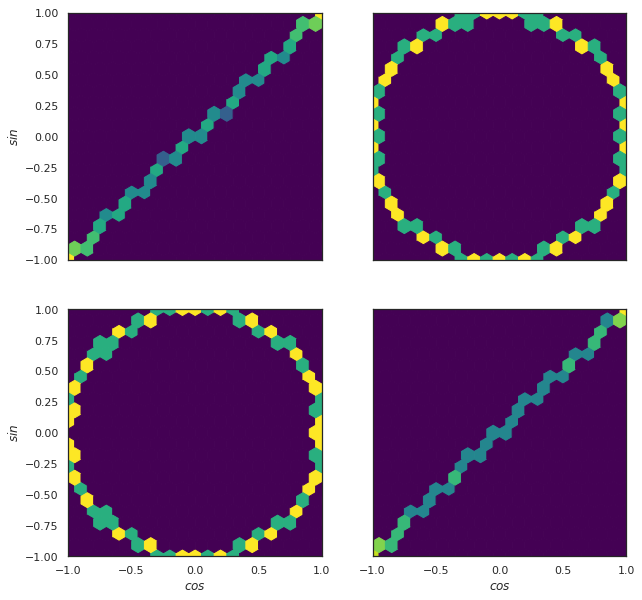

In [30]:
# EMF = [EMF_x, EMF_y] = [sin(x) cos(x)]
# B   = [B_x,   B_y]   = [sin(x) cos(x)]

testx1 = np.sin(np.linspace(0,2*np.pi,100))
testx2 = np.cos(np.linspace(0,2*np.pi,100))

testy1 = np.sin(np.linspace(0,2*np.pi,100))
testy2 = np.cos(np.linspace(0,2*np.pi,100))

#testy1 = np.sin(np.linspace(-np.pi,np.pi,100))
#testy2 = np.cos(np.linspace(-np.pi,np.pi,100))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10), sharex='col', sharey='row')

hb = ax1.hexbin(testx1, testy1, gridsize=20, bins='log', cmap='viridis')
ax1.axis([testx1.min(),testx1.max(),testy1.min(),testy1.max()])
#ax1.set_xlabel(r'$sin$', fontsize=12)
ax1.set_ylabel(r'$sin$', fontsize=12)

hb = ax2.hexbin(testx1, testy2, gridsize=20, bins='log', cmap='viridis')
ax2.axis([testx1.min(),testx1.max(),testy2.min(),testy2.max()])
#ax2.set_xlabel(r'$sin$', fontsize=12)
#ax2.set_ylabel(r'$cos$', fontsize=12)

hb = ax3.hexbin(testx2, testy1, gridsize=20, bins='log', cmap='viridis')
ax3.axis([testx2.min(),testx2.max(),testy1.min(),testy1.max()])
ax3.set_xlabel(r'$cos$', fontsize=12)
ax3.set_ylabel(r'$sin$', fontsize=12)

hb = ax4.hexbin(testx2, testy2, gridsize=20, bins='log', cmap='viridis')
ax4.axis([testx2.min(),testx2.max(),testy2.min(),testy2.max()])
ax4.set_xlabel(r'$cos$', fontsize=12)
#ax4.set_ylabel(r'$cos$', fontsize=12)

#fig.savefig('hexbin_allin1_sincosbasis.pdf', bbox_inches='tight')

## Correlation heatmap

In [14]:
def df_corr_plot(df,fname=None,t1=1000,t2=2000,scal=None,verbose=None,savfig=False,labs=None):
    if fname:
        print('Using file: ',fname)
        df = gen_df_tave(fname=fname,t1=t1,t2=t2,verbose=verbose)
    if scal:
        print('Scaling data before plotting correlations')
        df_ss, _ = scale_df(df)
        df       = df_ss.copy()

    corr_matrix = df.corr()

    sns.set(style="white")

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix, annot=True, cbar=False, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

    if labs is None:
        labs = [r'$\overline{B}_x$',r'$\overline{B}_y$',r'$\overline{J}_x$',r'$\overline{J}_y$',r'$\mathcal{E}_x$',r'$\mathcal{E}_y$']

    #ax.set_xticklabels(labels=df.columns,fontsize=16,rotation=45)
    #ax.set_yticklabels(labels=df.columns,fontsize=16,rotation=45)
    ax.set_xticklabels(labels=labs,fontsize=20,rotation=45)
    ax.set_yticklabels(labels=labs,fontsize=20,rotation=45)
    #ax.set_yticklabels(labels=labs[::-1],fontsize=16,rotation=45)

    if savfig:
        try:
            os.makedirs("correlation")
        except FileExistsError:
        # directory already exists
            pass
        savfile = 'correlation/corr.pdf'
        fig.savefig(savfile,bbox_inches='tight')

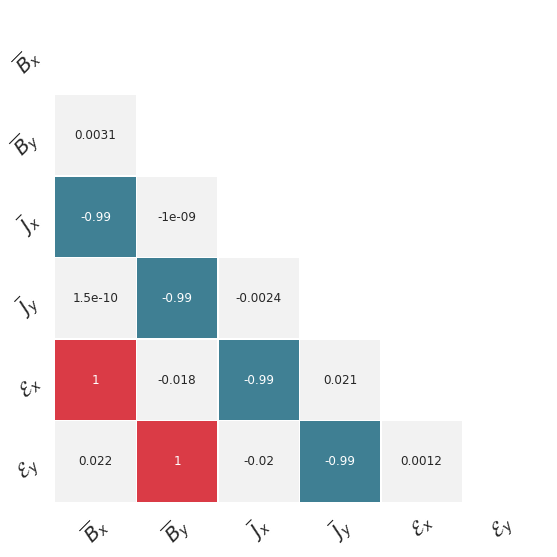

In [15]:
df_corr_plot(data_ss)